In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2]:
# Primary dataset
df1 = pd.read_csv("Used Cars.csv")

# Secondary dataset (aligned Craigslist sample)
df2 = pd.read_csv("vehicles_small_aligned.csv")

print("Primary dataset:", df1.shape)
print("Secondary dataset:", df2.shape)

Primary dataset: (4009, 12)
Secondary dataset: (5000, 10)


In [3]:
df1_clean = df1.copy()

df1_clean = df1_clean.dropna(subset=["Price", "Model_year", "Milage"])

df1_clean = df1_clean[(df1_clean["Price"] > 2000) & (df1_clean["Price"] < 100000)]

df1_clean = df1_clean[(df1_clean["Milage"] >= 0) & (df1_clean["Milage"] <= 300000)]

df1_clean["Age"] = 2024 - df1_clean["Model_year"]
df1_clean["Age"] = df1_clean["Age"].clip(lower=1)

df1_clean["Miles_per_year"] = df1_clean["Milage"] / df1_clean["Age"]

print(df1_clean.shape)
df1_clean.head()

(3768, 14)


,Brand,Model,Model_year,Milage,Fuel_type,Engine,Transmission,Ext_col,Int_col,Accident,Clean_title,Price,Age,Miles_per_year
0,Volvo,X3 xDrive30i,2020,99999,Gasoline,248.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Brown,At least 1 accident or damage reported,Yes,40000,4,24999.750000
1,Volvo,F-150 Raptor,2020,99982,Gasoline,450.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,Blue,Black,None reported,Yes,62999,4,24995.500000
2,Volvo,Taycan,2022,99941,NaN,Electric,Automatic,Black,Black,None reported,NaN,90998,2,49970.500000
3,Volvo,S4 3.0T Premium Plus,2022,99915,Gasoline,349.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,53900,2,49957.500000
5,Volvo,E-Class E 300 4MATIC,2018,99769,Gasoline,241.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Black,Black,At least 1 accident or damage reported,Yes,25900,6,16628.166667


In [4]:
df2_clean = df2.copy()

df2_clean = df2_clean.dropna(subset=["Price", "Model_year", "Milage"])

df2_clean = df2_clean[(df2_clean["Price"] > 2000) & (df2_clean["Price"] < 100000)]

df2_clean = df2_clean[(df2_clean["Milage"] >= 0) & (df2_clean["Milage"] <= 300000)]

df2_clean["Age"] = 2024 - df2_clean["Model_year"]
df2_clean["Age"] = df2_clean["Age"].clip(lower=1)
df2_clean["Miles_per_year"] = df2_clean["Milage"] / df2_clean["Age"]

print(df2_clean.shape)
df2_clean.head()

(4957, 12)


,Price,Model_year,Milage,Brand,Model,Fuel_type,Transmission,Accident,Clean_title,condition,Age,Miles_per_year
0,24590,2013.0,80318.0,gmc,sierra 1500 extended cab slt,other,other,Unknown,Clean,good,11.0,7301.636364
1,36499,2013.0,108174.0,chevrolet,2500hd lt duramax 4x4,diesel,automatic,Unknown,Clean,NaN,11.0,9834.000000
2,9970,2016.0,42407.0,kia,forte lx,gas,automatic,Unknown,Clean,excellent,8.0,5300.875000
3,23500,2015.0,33875.0,mercedes-benz,gla,gas,automatic,Unknown,Clean,NaN,9.0,3763.888889
4,53986,2020.0,18729.0,acura,mdx,gas,automatic,Unknown,Clean,NaN,4.0,4682.250000


In [5]:
df_combined = pd.concat([df1_clean, df2_clean], ignore_index=True)
df_combined.shape

(8725, 15)

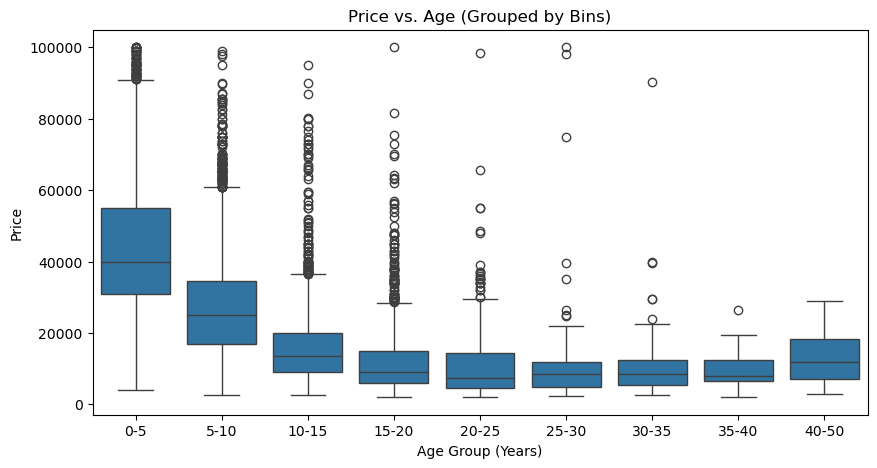

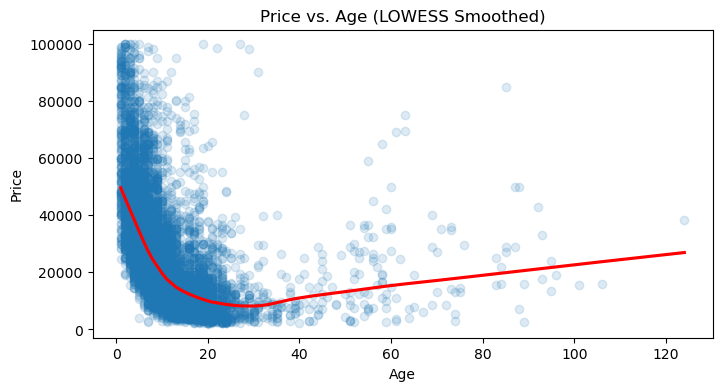

In [7]:
df_combined["Age_bin"] = pd.cut(
    df_combined["Age"],
    bins=[0,5,10,15,20,25,30,35,40,50],
    labels=["0-5","5-10","10-15","15-20","20-25","25-30","30-35","35-40","40-50"]
)

plt.figure(figsize=(10,5))
sns.boxplot(data=df_combined, x="Age_bin", y="Price")
plt.title("Price vs. Age (Grouped by Bins)")
plt.xlabel("Age Group (Years)")
plt.ylabel("Price")
plt.show()

# Price vs Age (LOWESS)
plt.figure(figsize=(8,4))
sns.regplot(
    data=df_combined,
    x="Age",
    y="Price",
    scatter_kws={'alpha':0.15},
    lowess=True,
    line_kws={'color':'red'}
)
plt.title("Price vs. Age (LOWESS Smoothed)")
plt.show()

In [10]:
target = "Price"

numeric_features = ["Milage", "Age", "Miles_per_year"]
categorical_features = ["Brand", "Model", "Fuel_type", "Transmission", "Accident", "Clean_title"]

X = df_combined[numeric_features + categorical_features]
y = df_combined[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [12]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(max_depth=10, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
}

results = []

for name, model in models.items():
    pipe = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", model)
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2
    })

results_df = pd.DataFrame(results)
results_df.sort_values("RMSE")

,Model,MAE,RMSE,R2
2,Random Forest,7346.102168,11577.860474,0.626929
3,Gradient Boosting,8680.415417,12179.899888,0.587122
1,Decision Tree,9118.015878,12972.050439,0.531670
0,Linear Regression,8230.758774,13046.863117,0.526253


In [13]:
for name, model in models.items():
    pipe = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", model)
    ])
    pipe.fit(X_train, y_train)

    r2_train = pipe.score(X_train, y_train)
    r2_test = pipe.score(X_test, y_test)

    print(f"{name}: Train R² = {r2_train:.3f}, Test R² = {r2_test:.3f}")

Linear Regression: Train R² = 0.915, Test R² = 0.526
Decision Tree: Train R² = 0.654, Test R² = 0.532
Random Forest: Train R² = 0.952, Test R² = 0.627
Gradient Boosting: Train R² = 0.635, Test R² = 0.587


In [14]:
gb = GradientBoostingRegressor(random_state=42)

gb_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", gb)
])

gb_pipe.fit(X_train, y_train)

ohe = gb_pipe.named_steps["preprocess"].transformers_[1][1].named_steps["onehot"]
cat_names = ohe.get_feature_names_out(categorical_features)
feature_names = numeric_features + list(cat_names)

importances = gb_pipe.named_steps["model"].feature_importances_

feat_imp = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

feat_imp.head(15)

,Feature,Importance
1,Age,0.681577
3559,Fuel_type_diesel,0.038823
3561,Fuel_type_gas,0.037226
0,Milage,0.026418
3620,Accident_None reported,0.020027
3621,Accident_Unknown,0.014094
418,Model_911 Carrera S,0.013546
3554,Fuel_type_Diesel,0.010748
1370,Model_R1S Adventure Package,0.007000
3585,Transmission_7-Speed A/T,0.006549


In [17]:
fitted_pipes = {}

for name, model in models.items():
    pipe = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", model)
    ])
    pipe.fit(X_train, y_train)
    fitted_pipes[name] = pipe

fitted_pipes.keys()

dict_keys(['Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting'])

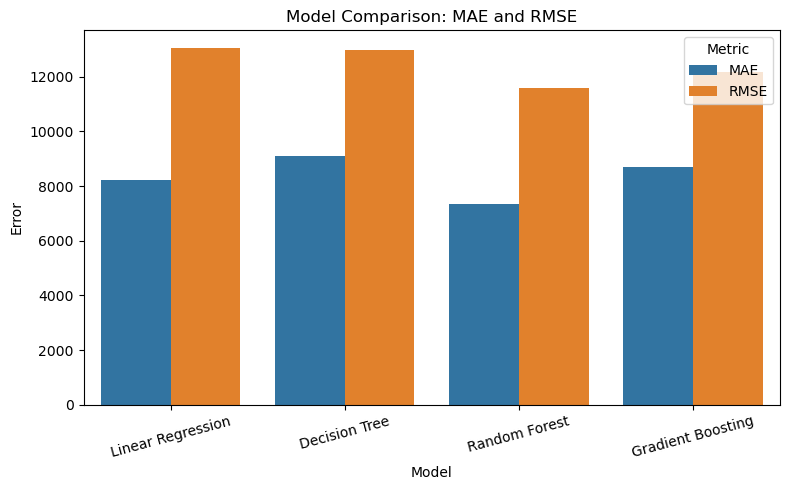

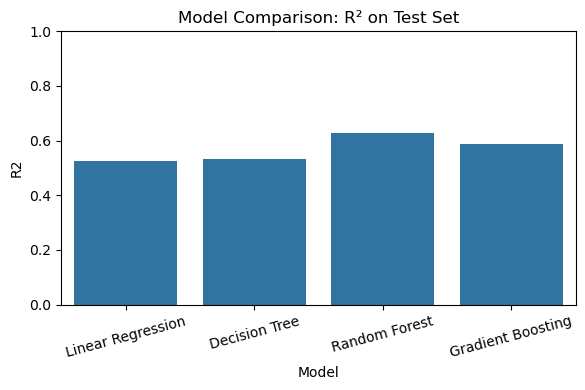

In [18]:
results_long = results_df.melt(
    id_vars="Model",
    value_vars=["MAE", "RMSE"],
    var_name="Metric",
    value_name="Value"
)

plt.figure(figsize=(8,5))
sns.barplot(data=results_long, x="Model", y="Value", hue="Metric")
plt.title("Model Comparison: MAE and RMSE")
plt.ylabel("Error")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
sns.barplot(data=results_df, x="Model", y="R2")
plt.title("Model Comparison: R² on Test Set")
plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

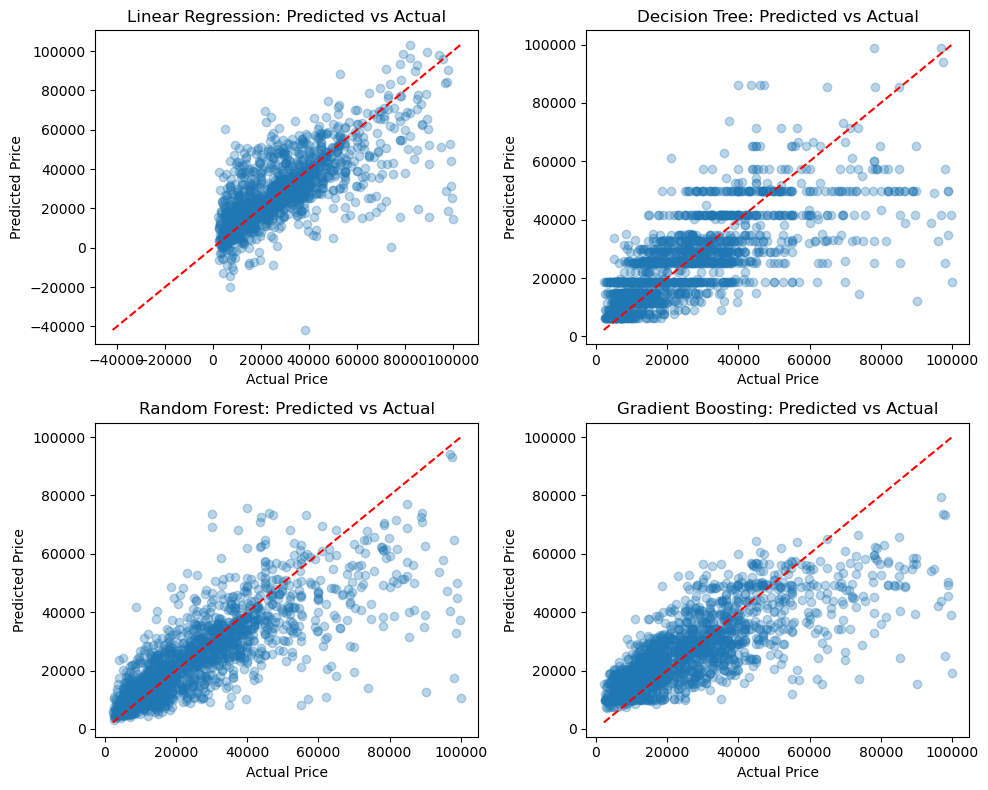

In [19]:
plt.figure(figsize=(10,8))

for i, (name, pipe) in enumerate(fitted_pipes.items(), start=1):
    y_pred = pipe.predict(X_test)
    
    plt.subplot(2, 2, i)
    plt.scatter(y_test, y_pred, alpha=0.3)
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], "r--")  # 45° line
    plt.title(f"{name}: Predicted vs Actual")
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")

plt.tight_layout()
plt.show()

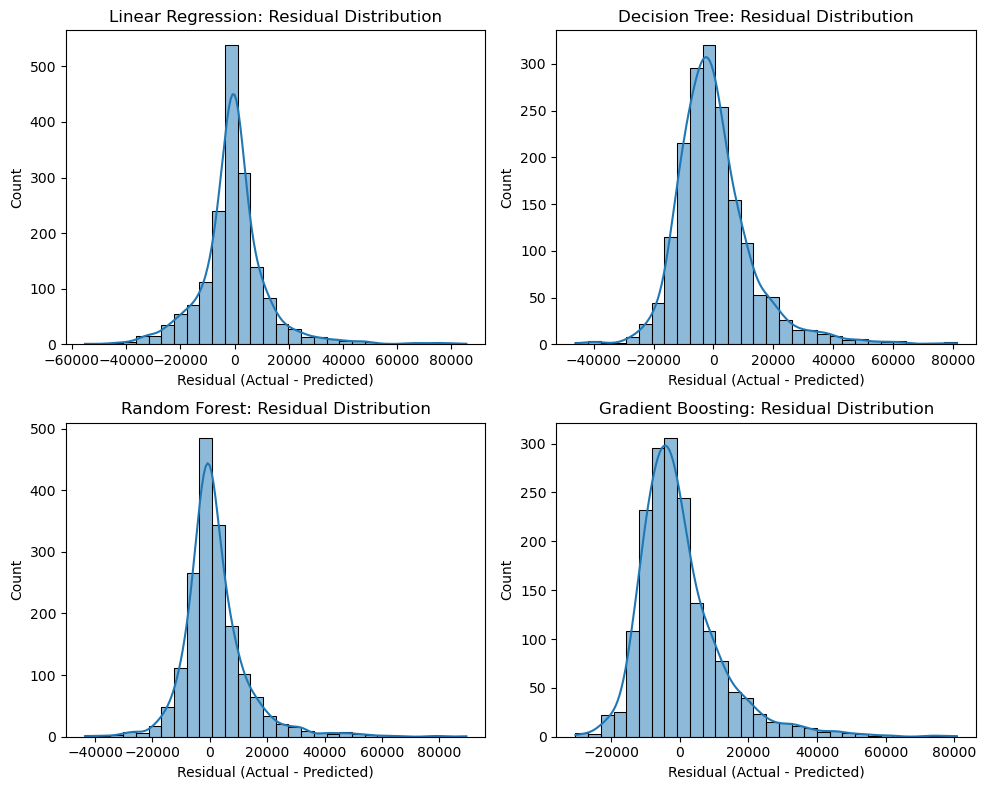

In [21]:
plt.figure(figsize=(10,8))

for i, (name, pipe) in enumerate(fitted_pipes.items(), start=1):
    y_pred = pipe.predict(X_test)
    residuals = y_test - y_pred
    
    plt.subplot(2, 2, i)
    sns.histplot(residuals, bins=30, kde=True)
    plt.title(f"{name}: Residual Distribution")
    plt.xlabel("Residual (Actual - Predicted)")
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

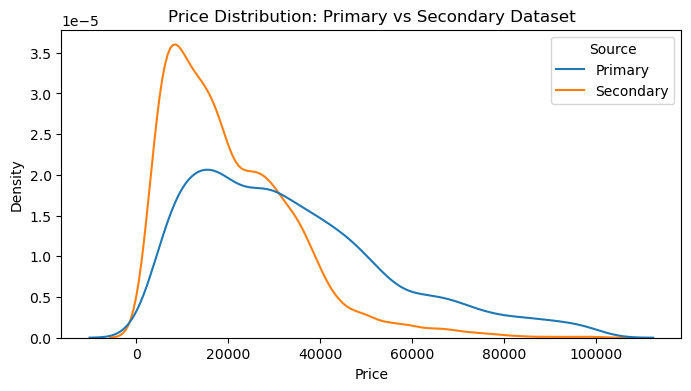

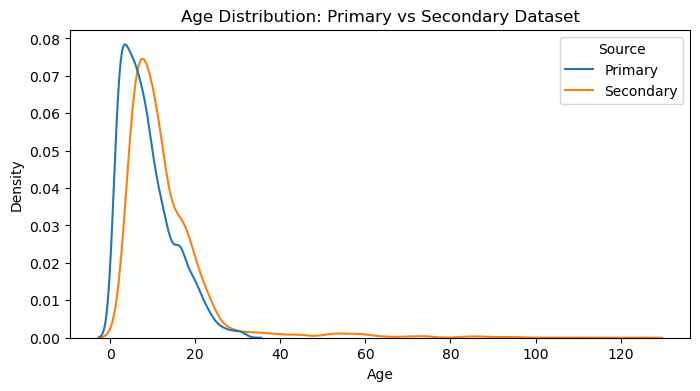

In [23]:
df1_src = df1_clean.copy()
df1_src["Source"] = "Primary"

df2_src = df2_clean.copy()
df2_src["Source"] = "Secondary"

df_combined_src = pd.concat([df1_src, df2_src], ignore_index=True)

plt.figure(figsize=(8,4))
sns.kdeplot(data=df_combined_src, x="Price", hue="Source", common_norm=False)
plt.title("Price Distribution: Primary vs Secondary Dataset")
plt.show()

plt.figure(figsize=(8,4))
sns.kdeplot(data=df_combined_src, x="Age", hue="Source", common_norm=False)
plt.title("Age Distribution: Primary vs Secondary Dataset")
plt.show()